# Brief Métier : Exploitation des Données Scrappées avec Pandas

## Contexte Professionnel

Après la phase de **scraping** réalisée sur des sites concurrents de Castorama, vous avez obtenu deux fichiers CSV :

- categories.csv : contenant les informations relatives aux catégories et sous-catégories.
- products.csv : contenant les informations relatives aux produits (nom, prix, disponibilité, promotions, etc.).

En tant que **Data Analyst / Data Engineer**, votre rôle est désormais de **nettoyer**, **préparer** et **analyser** ces données afin d’en extraire des **informations pertinentes**. Ces informations permettront à Castorama de mieux comprendre l’état du marché, de mettre en place une stratégie tarifaire compétitive et d'anticiper les tendances.

## Installations

In [ ]:
%pip install --upgrade pip
%pip install ipykernel
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install graphviz

## Importations

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import re
import logging

## Chargement des Données

In [5]:
# Load category data
category_data = pd.read_csv("castorama_categories.csv")

# Load products data
product_data = pd.read_csv("castorama_products.csv")

In [ ]:
# Confirm category data loaded correctly
category_data

In [ ]:
# Confirm product data loaded correctly
product_data

## Exploration

### Aperçu des données

In [ ]:
# Get information about category_data
category_data.info()

In [ ]:
# Get information about product_data
product_data.info()

In [ ]:
# View category_data summary statistics 
category_data.describe()

In [ ]:
# View product_data summary statistics 
product_data.describe()

In [ ]:
# View first 5 data in category_data
category_data.head()

In [ ]:
# View first 5 data in product_data
product_data.head()

## Nettoyage et Préparation des Données

### Category_data.csv

In [6]:
# Duplicate raw data
cdf = category_data.copy()

In [ ]:
# Check for missing data
cdf.isna().sum()

In [4]:
# View duplicated categories 
duplicates = cdf[cdf["category"].duplicated(keep=False)]

In [ ]:
# Sort duplicates to understand patterns
duplicates.sort_values(by=['is_page_list','category', 'url'], ascending=False)

In [ ]:
# Sort data by the specified columns
cdf.sort_values(by=['is_page_list','category', 'url'], ascending=False)

In [ ]:
# Drop duplicates (keep only first occurrence)
cdf.drop_duplicates(subset=["category"], inplace=True, keep='first')

# View data
cdf.describe()

In [ ]:
# View duplicated urls
duplicated_urls = cdf[cdf["url"].duplicated(keep=False)]

# Sort by url
duplicates_sorted = duplicated_urls.sort_values(by="is_page_list", ascending=False)

# View data
duplicates_sorted

In [ ]:
# Sort data by "is_page_list"
cdf.sort_values(by='is_page_list', ascending=False)

In [ ]:
# Drop duplicate urls (Observation: Double is_page_list created for SEO and Diacritics)

cdf.drop_duplicates(subset=["url"], inplace=True, keep='first')

# Summarize data
cdf.describe()

- Manipulation de chaînes :

In [8]:
# Remove trailing spaces and characters in category name
cdf["category"] = cdf["category"].str.strip()

In [9]:
# Convert category names to lowercase
cdf['category'] = cdf['category'].str.lower()

In [10]:
# Handling encoding issues (trailing underscores, Prefix 0s, multiple underscores) in specified columns
# Replace spaces, commas, apostrophes with underscore

logging.basicConfig(level=logging.ERROR)

# Define function to clean category texts
def clean_text(input_str):
    """
    Standardize and clean text input by transforming special characters and whitespace.

    Args:
        input_str (str or None): Input string to be cleaned.

    Returns:
        str or None: Cleaned string with standardized formatting.

    Raises:
        TypeError: If input is not a string, None, or NaN.
    """
    try:
        if pd.isnull(input_str):  # Handle NaN values
            return input_str
        
        if not isinstance(input_str, (str, int, float)):
            raise TypeError(f"Expected string, got {type(input_str)}")
        
        input_str = str(input_str)  # Ensure the input is a string
        
        input_str = re.sub(r'[\u002D\u2010\u2011\u2012\u2013\u2014\u2212]', '_', input_str) # Replace all hyphen types
        input_str = re.sub(r'\s+', '_', input_str.strip()) # Replace all whitespace with underscores
        input_str = input_str.replace(',', '_') # Replace commas with underscores 
        input_str = input_str.replace("'", '_') # Replace apostrophes with underscores
        input_str = re.sub(r'_+', '_', input_str) # Remove multiple underscores
        input_str = re.sub(r'^_|_$', '', input_str) # Remove leading or trailing underscores
        input_str = re.sub(r'^0+', '', input_str) # Remove leading zeros
        
        return input_str
    
    except Exception as e:
        logging.error(f"Error in category clean_text: {e}")
        raise

# Apply function to clean category text
cdf['category'] = cdf['category'].map(clean_text)

In [11]:
# Declare text replacement characters
replacements = {"à": "a", "á": "a", "â": "a", "ä": "a", "ç" : "c",
                "é": "e", "è": "e", "ê": "e", "ë": "e", "É":"E", "È":"E",
                "î": "i", "ï":"i", "ì": "i", "í": "i",
                "ö": "o", "ô": "o", "ò": "o", "ó": "o",
                "ü": "u", "û": "u", "ù": "u", "ú": "u"}

# Define function to replace accented category texts
def replace_accents(input_str, replacement):
    """
    Replace specific accented characters in a string using a provided replacement dictionary.

    Args:
        input_str (str): Input string to be processed.
        replacement (dict): Dictionary mapping accented characters to their replacements.

    Returns:
        str: String with specified characters replaced.

    Raises:
        TypeError: If input_str is not a string or replacement is not a dictionary.
        ValueError: If replacement dictionary is empty.

    Examples:
        >>> replacements = {'é': 'e', 'à': 'a'}
        >>> replace_accents("Café", replacements)
        'Cafe'
    """
    try:
        # Validate input types
        if not isinstance(input_str, str):
            raise TypeError(f"Expected string for input_str, got {type(input_str)}")
        
        if not isinstance(replacement, dict):
            raise TypeError(f"Expected dictionary for replacement, got {type(replacement)}")
        
        if not replacement:
            raise ValueError("Replacement dictionary cannot be empty")

        # Perform replacements
        for old, new in replacement.items():
            input_str = input_str.replace(old, new)
        
        return input_str

    except Exception as e:
        logging.error(f"Error in category replace_accents: {e}")
        raise

# Apply function to remove accents
cdf["category"] = cdf["category"].apply(lambda x: replace_accents(str(x), replacements))

In [ ]:
# Review for errors or duplicates
cdf.sort_values(by='category')

In [ ]:
# Verify again if duplicates persists
c_duplicates = cdf[cdf['category'].duplicated(keep=False)]

# Sort by category
c_duplicates.sort_values(by='category')

In [14]:
# Sort by is_page_list
cdf_sorted = cdf.sort_values(by="is_page_list", ascending=False)

In [15]:
# Drop newly found duplicates (SEO / Diacritics related, keep only "True" is_page_lists)
cdf_no_duplicates = cdf_sorted.drop_duplicates(subset=['category'], keep='first')

In [16]:
# Sort by original index
cdf_no_duplicates = cdf_no_duplicates.sort_index()

In [17]:
# Duplicate original index
cdf_no_duplicates["original_index"] = cdf_no_duplicates.index

In [18]:
# Reset index
categories_cleaned = cdf_no_duplicates.reset_index(drop=True)

In [19]:
# Exclude original index from final copy
categories_cleaned_final = categories_cleaned[['category', 'is_page_list', 'url']]

In [39]:
# Export cleaned data
categories_cleaned_final.to_csv("categories_cleaned_final.csv", index=False)

### Product_data.csv

In [106]:
# Duplicate raw product data
pdf = product_data.copy()

In [ ]:
# Get info about products data
pdf.info()

In [ ]:
# Get summary statistics/info
pdf.describe()

In [ ]:
# Check for missing values (general)
pdf.isna()

In [ ]:
# Check for missing values in unique_id column
pdf["unique_id"].isna().value_counts()

In [ ]:
# Check for missing values (category column)
pdf["category"].isna().value_counts()

In [ ]:
# Check for missing values (subcategory column)
pdf["subcategory"].isna().value_counts()

In [ ]:
# Check for missing values (subsubcategory column)
pdf["subsubcategory"].isna().value_counts()

In [ ]:
# Check for missing values (subsubsubcategory column)
pdf["subsubsubcategory"].isna().value_counts()

In [ ]:
# Check for missing values (price column)
pdf["price"].isna().value_counts()

In [ ]:
# Check for missing values (title column) 
pdf["title"].isna().value_counts()

In [ ]:
# Check for missing values (url column)
pdf["url"].isna().value_counts()

In [ ]:
# Show summary statistics
pdf.describe()

In [ ]:
# View duplicates (if any)
duplicates_in_pdf = pdf[pdf.duplicated(subset="title", keep=False)]

duplicates_in_pdf

# Note: Duplicates were not removed because each entry represents a distinct variation of a product (e.g., different color or size) with a unique ID. 
# While some fields like title, category, or subcategory may be identical, these variations provide important granularity for analysis.

- Manipulation de chaînes :

In [ ]:
# Replace NaNs
pdf['subsubsubcategory'] = pdf['subsubsubcategory'].fillna("Not_available")

In [51]:
# Convert specified columns to lowercase 
columns_to_lowercase = ['category', 'subcategory', 'subsubcategory', 'subsubsubcategory', 'title']
pdf[columns_to_lowercase] = pdf[columns_to_lowercase].apply(lambda x: x.str.lower())

In [52]:
# Strip values in the specified columns 
columns_to_strip = ['category', 'subcategory', 'subsubcategory', 'subsubsubcategory', 'title']
pdf[columns_to_strip] = pdf[columns_to_strip].apply(lambda x: x.str.strip())

In [53]:
# Handling encoding issues (trailing underscores, Prefix 0s, multiple underscores) in specified columns
# Replace spaces, commas, apostrophes with underscore


columns_to_replace = ['category', 'subcategory', 'subsubcategory', 'subsubsubcategory', 'title']

def clean_text(input_str):
    """
    Standardize and clean text input by transforming special characters and whitespace.

    Args:
        input_str (str or None): Input string to be cleaned.

    Returns:
        str or None: Cleaned string with standardized formatting.

    Raises:
        TypeError: If input is not a string, None, or NaN.
    """
    try:
        if pd.isnull(input_str):  # Handle NaN values
            return input_str
        
        if not isinstance(input_str, (str, int, float)):
            raise TypeError(f"Expected string, got {type(input_str)}")
        
        input_str = str(input_str)  # Ensure the input is a string
        
        input_str = re.sub(r'[\u002D\u2010\u2011\u2012\u2013\u2014\u2212]', '_', input_str) # Replace all hyphen types
        input_str = re.sub(r'\s+', '_', input_str.strip()) # Replace all whitespace with underscores
        input_str = input_str.replace(',', '_') # Replace commas with underscores 
        input_str = input_str.replace("'", '_') # Replace apostrophes with underscores
        input_str = re.sub(r'_+', '_', input_str) # Remove multiple underscores
        input_str = re.sub(r'^_|_$', '', input_str) # Remove leading or trailing underscores
        input_str = re.sub(r'^0+', '', input_str) # Remove leading zeros
        
        return input_str
    
    except Exception as e:
        logging.error(f"Error in product clean_text: {e}")
        raise

# Apply function to specified columns
pdf[columns_to_replace] = pdf[columns_to_replace].map(clean_text)

In [54]:
# Replace accented letters in the specified columns' texts

def robust_remove_accents(input_str):
    """
    Remove accented characters from input string, converting to their base ASCII equivalents.

    Args:
        input_str (str): Input string containing accented characters.

    Returns:
        str: String with accented characters replaced by their non-accented equivalents.

    Raises:
        TypeError: If input is not a string.
        ValueError: If input processing fails.

    Examples:
        >>> robust_remove_accents("héllô")
        'hello'
        >>> robust_remove_accents("Café")
        'Cafe'
    """
    try:
        # Validate input type
        if not isinstance(input_str, str):
            raise TypeError(f"Expected string, got {type(input_str)}")

        # Normalize to decomposed form
        normalized = unicodedata.normalize('NFD', input_str)

        # Remove combining characters (accents)
        without_accents = ''.join(c for c in normalized if unicodedata.category(c) != 'Mn')

        # Explicitly replace problematic characters (if any remains)
        replacements = {"à": "a", "á": "a", "â": "a", "ä": "a", "ç": "c", "ć": "c",
                    "é": "e", "è": "e", "ê": "e", "ë": "e", "É":"E", "È":"E",
                    "î": "i", "ï":"i", "ì": "i", "í": "i",
                    "ö": "o", "ô": "o", "ò": "o", "ó": "o",
                    "ü": "u", "û": "u", "ù": "u", "ú": "u"}

        for accented_char, replacement in replacements.items():
            without_accents = without_accents.replace(accented_char, replacement)
        
        # Handle lingering issues and strip
        return without_accents.replace('\xa0', ' ').strip()

    except Exception as e:
        logging.error(f"Error in product robust_remove_accents: {e}")
        raise

# Apply function
pdf[columns_to_replace] = pdf[columns_to_replace].map(
    lambda x: robust_remove_accents(str(x)) if isinstance(x, str) else x)

In [ ]:
# Replace commans with full stops and remove spaces bewteen numbers
pdf['price'] = pdf['price'].apply(lambda x: x.replace(",", "."))
pdf['price'] = pdf['price'].apply(lambda x: x.replace(" ", ""))

# Convert price column to float type
pdf['price'] = pd.to_numeric(pdf['price'], errors='coerce')

In [ ]:
# Display count of prices with NaN
pdf['price'].isna().value_counts()

In [ ]:
# Show rows with NaNs to understand the problem
pdf_nas = pdf[pdf.isna().any(axis=1)]

pdf_nas

In [62]:
# Replace NaNs with None
pdf['price'] = pdf['price'].replace({pd.NA: None, np.nan: None})

# Drop rows with NaN
pdf = pdf.dropna(subset=['price'])

In [67]:
# Store copy of original index
pdf['original_index'] = pdf.index

In [70]:
# Reset index
products_cleaned = pdf.reset_index(drop=True)

In [83]:
# Ensure price is in float format
products_cleaned['price'] = pd.to_numeric(products_cleaned['price'], errors='coerce')

# Select specific columns to be saved to the final file
products_cleaned_final = products_cleaned[['unique_id','category','subcategory', 'subsubcategory', 'subsubsubcategory', 'title', 'price', 'url']]

In [85]:
# Save cleaned file to csv
products_cleaned_final.to_csv("products_cleaned_final.csv", index=False)

## Analyse et visualisation des données

### Categories.csv

In [8]:
# Load data
cat = pd.read_csv("categories_cleaned_final.csv")

In [9]:
# Create a copy of the raw data
cat_df = cat.copy()

In [11]:
# Count number of page_lists
pagelist_num = cat_df['is_page_list'].value_counts()

# Store result in dataframe
pagelist_num = pd.DataFrame(pagelist_num)

# Reset dataframe index
pagelist_num = pagelist_num.reset_index()

In [12]:
# Show dataframe
pagelist_num

,is_page_list,count
0,False,1357
1,True,15


### Products.csv

In [17]:
# Load data
prod = pd.read_csv("products_cleaned_final.csv")

In [18]:
# Create a copy of the raw data
prod_df = prod.copy()


In [ ]:
# view data
prod_df

In [19]:
# Calculate the number of products by category
len_products = prod_df.groupby('category').size()

# Make table a dataframe
products_len_df = pd.DataFrame(len_products, columns=["num_of_products"]).reset_index()

# Show dataframe
products_len_df

,category,num_of_products
0,carrelage_sol,49
1,chauffage_climatisation_et_ventilation,3692
2,cuisine,30
3,decoration_interieure,8276
4,droguerie_entretien_de_la_maison,523
5,electricite,221
6,jardin_et_terrasse,394
7,luminaire_et_eclairage,540
8,maison_connectee_domotique_et_objet_connecte,96
9,materiaux_et_gros_oeuvre,62


In [112]:
# Show summary statistics
prod_df.describe()

,price
count,28308.000000
mean,145.151554
std,270.757478
min,0.500000
25%,20.760000
50%,48.995000
75%,136.990000
max,5890.000000


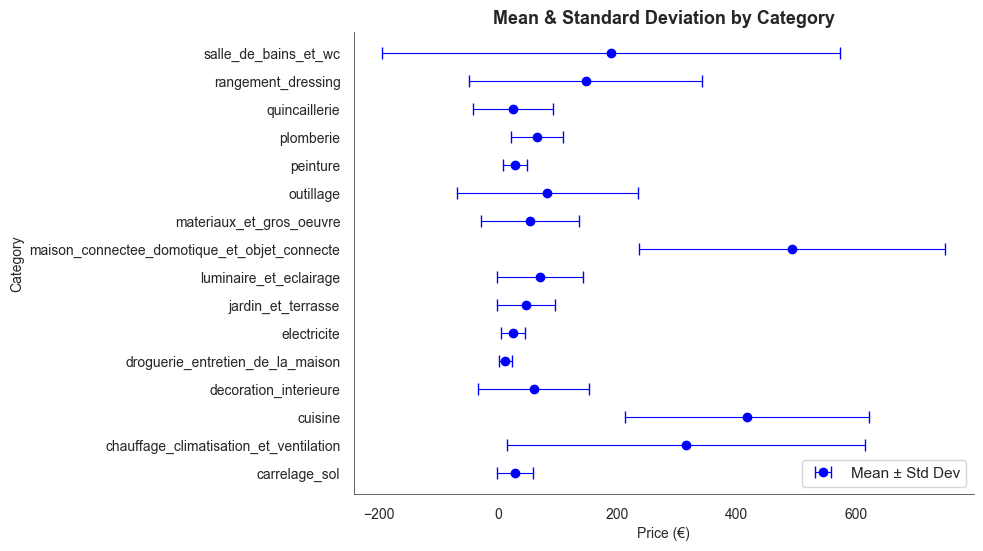

In [113]:
# override the default matplotlib style, to avoid the grey background and grid
sns.set_style("white") 

# Group by category and calculate statistics
stats = prod_df.groupby('category')['price'].agg(['mean', 'std', 'min', 'max']).reset_index()

# Plot mean with horizontal error bars for std deviation
plt.figure(figsize=(8, 6))
plt.errorbar(
    stats['mean'], stats['category'], 
    xerr=stats['std'], fmt='o', capsize=4, label='Mean ± Std Dev', color='blue', elinewidth=0.8
)

# Adjust plot border width
for spine in plt.gca().spines.values():  # Access all spines
    spine.set_linewidth(0.5)  # Set the border (spine) line width

# Add labels, title, and adjust axes params
plt.title('Mean & Standard Deviation by Category', fontsize = 13, weight = "bold")
plt.ylabel('Category', fontsize = 10)
plt.xlabel('Price (€)', fontsize = 10)
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.legend()
sns.despine()
plt.show()

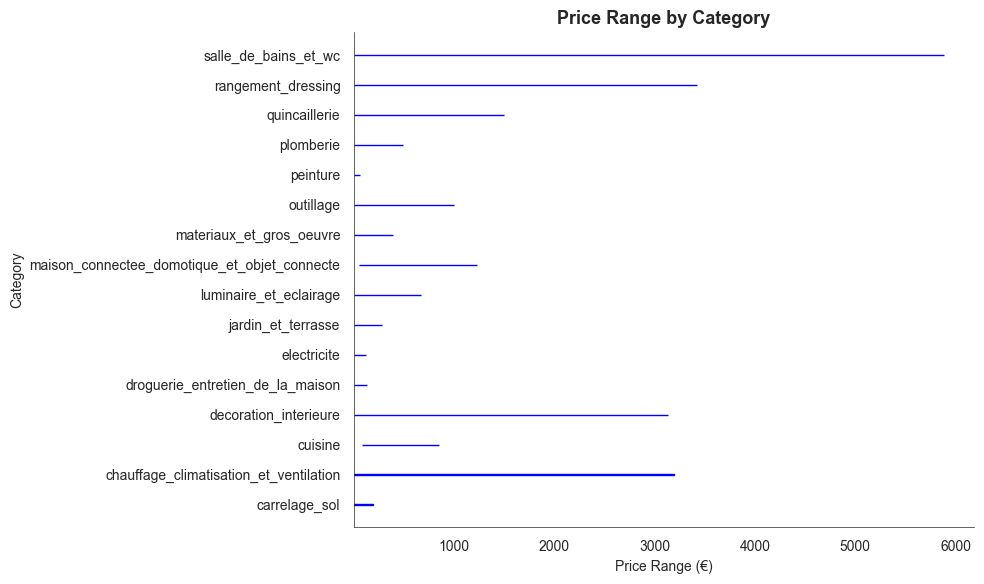

In [114]:
# override the default matplotlib style, to avoid the grey background and grid
sns.set_style("white") 

# Prepare the y positions, x_bot, and x_dif
y = np.arange(len(stats))  # positions for the categories
x_bot = stats['min']       # minimum price as the start of the bar
x_dif = stats['max'] - stats['min']  # range of the prices as the bar width

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(y, x_dif, left=x_bot, color='skyblue', edgecolor='blue', height=0.01)

# Adjust plot border width
for spine in plt.gca().spines.values():  # Access all spines
    spine.set_linewidth(0.5)  # Set the border (spine) line width

# Add labels, title, and adjust awes params
plt.title('Price Range by Category', fontsize = 13, weight = "bold")
plt.ylabel('Category', fontsize = 10)  # Label for the y-axis
plt.xlabel('Price Range (€)', fontsize = 10)  # Label for the x-axis
plt.yticks(y, stats['category'], fontsize = 10)
plt.xticks(fontsize = 10)

# Show the plot
plt.tight_layout()
sns.despine()
plt.show()

In [115]:
# Get product details for the least and most expensive products by category
min_products = prod_df.loc[prod_df.groupby('category')['price'].idxmin(), ['category', 'title', 'price']]
max_products = prod_df.loc[prod_df.groupby('category')['price'].idxmax(), ['category', 'title', 'price']]

# Merge min and max product details
min_max_products = pd.merge(
    min_products,
    max_products,
    on='category',
    suffixes=('_min', '_max')
)

# Display table as dataframe
pd.DataFrame(min_max_products)

,category,title_min,price_min,title_max,price_max
0,carrelage_sol,decapant_laitance_et_voile_de_ciment_spado_pro...,6.99,protecteur_anti_taches_effet_naturel_fila_5l,189.00
1,chauffage_climatisation_et_ventilation,pompe_manuelle_de_remplissage_pour_tous_fluide...,2.60,poele_a_pellet_freepoint_zen_airtight_noir_9.3_kw,3190.00
2,cuisine,plan_de_travail_stratifie_aspect_chene_grise_g...,84.15,lave_linge_hublot_60_cm_9kg_1200_tours/min_bos...,850.32
3,decoration_interieure,crochets_escargots_rideau_goodhome_passe_tring...,1.40,tapis_shaggy_250x350_rectangle_fait_main_noise...,3129.88
4,droguerie_entretien_de_la_maison,recharge_tete_franges_coton_l.12_x_h.35_cm,1.60,serpilliere_electrique_karcher_ewm2_blanc,135.00
5,electricite,multiprise_3_prises_blanc_1_m_16a_3680w_230_v,2.75,projecteur_de_chantier_boch_18v_1900_lumens,119.00
6,jardin_et_terrasse,brosse_a_main_interieur_et_exterieur,2.29,balayeuse_aspirateur_pour_gazon_artificiel_rol...,279.00
7,luminaire_et_eclairage,spot_a_piquer_led_a_energie_solaire_ip44_0.06w...,0.90,zafferano_super_o_lampadaire_led_blanc_recharg...,675.00
8,maison_connectee_domotique_et_objet_connecte,controleur_wi_fi_konyks_pour_radiateurs_electr...,49.90,radiateur_electrique_double_coeur_de_chauffe_l...,1230.00
9,materiaux_et_gros_oeuvre,sachet_absorbeurs_d_humidite_20m²_500g,2.99,plaque_de_construction_a_carreler_en_mortier_d...,392.00


In [20]:
products_len_df

,category,num_of_products
0,carrelage_sol,49
1,chauffage_climatisation_et_ventilation,3692
2,cuisine,30
3,decoration_interieure,8276
4,droguerie_entretien_de_la_maison,523
5,electricite,221
6,jardin_et_terrasse,394
7,luminaire_et_eclairage,540
8,maison_connectee_domotique_et_objet_connecte,96
9,materiaux_et_gros_oeuvre,62


In [52]:
# Calculate the size of each category
category_counts = prod_df.groupby('category').size()

# Filter for categories with more than 200 products
categories_to_keep = category_counts[category_counts > 500].index

# Filter the original DataFrame
filtered_df = prod_df[prod_df['category'].isin(categories_to_keep)]

#  Select the first 200 rows per category

filtered_df = (
    filtered_df.sort_values(by=['category', 'price'])  # Sort by category and optionally by price
    .groupby('category')                              # Group by category
    .head(500)                                        # Take the first 200 rows per category
)


In [53]:
categories_to_keep

Index(['chauffage_climatisation_et_ventilation', 'decoration_interieure',
       'droguerie_entretien_de_la_maison', 'luminaire_et_eclairage',
       'quincaillerie', 'rangement_dressing', 'salle_de_bains_et_wc'],
      dtype='object', name='category')

In [54]:
columns_to_drop = ['unique_id', 'subcategory', 'subsubcategory', 'subsubsubcategory', 'title', 'url']

filtered_df = filtered_df.drop(columns_to_drop, axis=1)

In [55]:
# Reset the index to ensure sequential indexing
filtered_df = filtered_df.reset_index(drop=True)

# Create pivot table
pivoted = filtered_df.pivot_table(index=filtered_df.index % 500, columns='category', values='price', aggfunc='first')

pivoted

category,chauffage_climatisation_et_ventilation,decoration_interieure,droguerie_entretien_de_la_maison,luminaire_et_eclairage,quincaillerie,rangement_dressing,salle_de_bains_et_wc
0,2.60,1.40,1.60,0.90,0.9,0.50,1.00
1,2.69,1.50,1.95,7.90,0.9,0.50,1.50
2,2.74,1.90,2.19,8.90,0.9,0.75,2.00
3,2.90,1.95,2.49,9.73,0.9,1.00,2.45
4,2.90,2.50,2.59,9.90,1.0,1.00,2.60
...,...,...,...,...,...,...,...
495,29.90,11.90,25.90,129.72,27.9,11.90,12.50
496,29.90,11.90,25.90,130.82,27.9,11.90,12.50
497,29.90,11.90,26.90,130.82,27.9,11.90,12.50
498,29.90,11.90,27.90,131.00,27.9,11.90,12.50


In [56]:
category_corr = pivoted.corr()

In [57]:
# pd.reset_option('display.max_colwidth')
category_corr

category,chauffage_climatisation_et_ventilation,decoration_interieure,droguerie_entretien_de_la_maison,luminaire_et_eclairage,quincaillerie,rangement_dressing,salle_de_bains_et_wc
category,,,,,,,
chauffage_climatisation_et_ventilation,1.000000,0.946419,0.972771,0.981263,0.976670,0.991650,0.943146
decoration_interieure,0.946419,1.000000,0.881872,0.885928,0.874006,0.940765,0.979866
droguerie_entretien_de_la_maison,0.972771,0.881872,1.000000,0.986037,0.991414,0.966606,0.868073
luminaire_et_eclairage,0.981263,0.885928,0.986037,1.000000,0.995122,0.982200,0.876335
quincaillerie,0.976670,0.874006,0.991414,0.995122,1.000000,0.972735,0.862434
rangement_dressing,0.991650,0.940765,0.966606,0.982200,0.972735,1.000000,0.938682
salle_de_bains_et_wc,0.943146,0.979866,0.868073,0.876335,0.862434,0.938682,1.000000


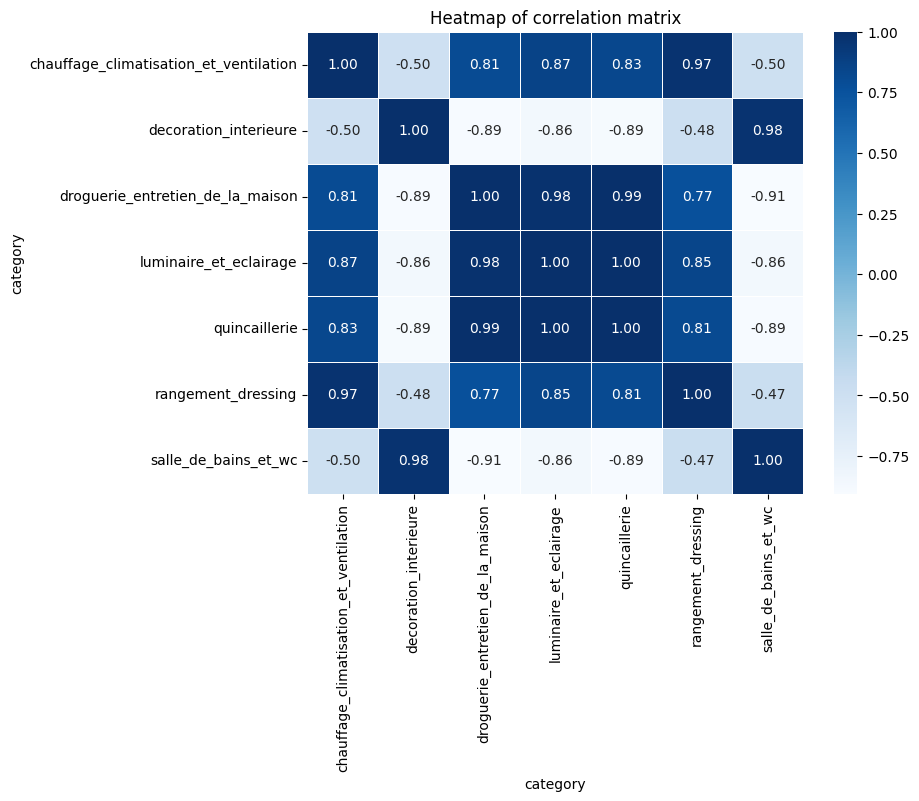

In [59]:
plt.figure(figsize=(8, 6))
sns.heatmap(category_corr.select_dtypes('number').corr(), 
            annot=True,
            cmap="Blues",
            fmt=".2f",
            linewidths=.5)

plt.title("Heatmap of correlation matrix")
plt.show()